In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from qutip.operators import destroy,create
import scipy.integrate as integrate

Constants

In [81]:
hbar = 1.054571e-34 # J*s
pi = np.pi
phi_0 = 2.06783384e-15 # Wb (or V*s)

In [82]:
# Parameters from the Paper
# Inductances (in H)
Lc = 10e-9
Lf = 10e-9
L1 =  10e-9
L2 =  10e-9
L3 =  10e-9
L4 =  10e-9

# Inductor Loop inductances
Ln0 = 1e-9
Ln1 =  10e-9
Ln2 =  10e-9
Ln3 =  10e-9
Ln4 =  10e-9
Ln5 = 2e-9
L_tot = Ln0 + Ln1 + Ln2 + Ln3 + Ln4 + Ln5

# Mutual Inducctances (in H)
Mc = 8e-9
Mf = 0.8e-9

# Due to Matching Conditions
M1 = 8e-9
M2 = 8e-9
M3 = 0.8e-9
M4 =0.8e-9
M12 = 7.023e-9
M34  = 7.023e-9
# Mutual Inductance between QET and first SQUID loop
M = 0.02e-9 # Henries 


# Coupling Coefficients
K_c = Mc / Lc
K_f = Mf / Lf
K12 = M12/Lc
K34 = M34/Lf


In [83]:
F = (Lc*Lf) *((-L_tot*Lf+Mf**2)*Lc+Lf*Mc**2)+(Lf+M34)*(L_tot*Lf-L_tot*M34-2*Mf**2)*M12**2 +(2*(Lf**2)*(Mc**2)-2*(M34**2)*(Mc**2))*M12+ Lc*((L_tot*Lc-2*Mc**2)*(M34**2)+2*Lc*Mf*Mf*M34+Lc*Lf*Mf**2 + (Lf**2)*(Mc**2))

Qubit Energy Tuner Functions

In [84]:
# Possibly Needed Functions

# Current through inductor Loop:
def i_p_loop(phi_A, phi_B, phi_C, phi_D):
    ''' 
    Computes current through inductor loop determined by Eq. 1
    INPUT:
    phi_(A/B/C/D): SFQ flux pulse (time integral of voltage at input A/B/C/D) in (Wb)
    OUTPUT:
    current through loop (in A)
    '''
    return (1/F) * ((phi_A -phi_B)*(Lf**2-M34**2)*(Lc+M12)*Mc+(phi_C-phi_D)*(Lc**2-M12**2)*(Lf+M34)*Mf)



def n(phi_in,phi_out): # Equations 3 and 4
    return ((phi_in - phi_out) / phi_0)

# Equations 5 and 6
def r(tuning = 'COARSE'):
    if tuning == 'COARSE':
       return (M/F) * (Lf**2 -M34**2)*(Lc + M12)*Mc
    else:
        return (M/F) * (Lc**2 -M12**2)*(Lf + M34)*Mf
    

# Currents from equations 7 and 8
def d_ip_tuned(tuning = 'COARSE'):
    ''' returns current in amperes'''
    if tuning == 'COARSE':
        return (1/F) *( Lf**2-M34**2)*(Lc+M12)*Mc*phi_0
    else:
        return (1/F) * (Lc**2 - M12**2)*(Lf+M34)*Mf*phi_0

def Phi_ext_current(di): # Equations 9 and 10 and 29
    ''' 
    compute the external flux through squid (use for both FINE and COARSE tuning)
    INPUT:
    di (Amperes): change in current
    '''
    return M*di 

# Equations 13 and 14
def Phi_ext_tuned(tuning = 'COARSE'):
    return r(tuning)* phi_0

# Equation 11
def i_p_quantized(phi_A, phi_B, phi_C, phi_D): 
    n_c = n(phi_A,phi_B)
    n_f = n(phi_C,phi_D)
   # print(n_c)
   # print(n_f)
    d_ipc = d_ip_tuned("COARSE")
    #print(d_ipc)
    d_ipf = d_ip_tuned("FINE")
    #print(d_ipf)
    return n_c * d_ipc + n_f * d_ipf

# Equation 12
def Phi_ext_flux(phi_A, phi_B, phi_C, phi_D):
    n_c = n(phi_A,phi_B)
    n_f = n(phi_C,phi_D)
    Phi_ec = M * d_ip_tuned("COARSE")
    Phi_ef = M * d_ip_tuned("FINE")
    return n_c * Phi_ec + n_f * Phi_ef

def plot_current(t,phiA,phiB,phiC,phiD):
    ip = np.zeros(len(t))
    for ii in range(len(t)):
        if phiA[ii] != 0 or phiB[ii] != 0 or phiC[ii] != 0 or phiD[ii] != 0:
            ip[ii:-1]+=i_p_quantized(phiA[ii], phiB[ii], phiC[ii], phiD[ii])
        #if phiB[ii] != 0:
        #    ip[ii:-1]+=i_p_quantized(phiA[ii], phiB[ii], phiC[ii], phiD[ii])
        #if phiC[ii] != 0:
        #    ip[ii:-1]+=i_p_quantized(phiA[ii], phiB[ii], phiC[ii], phiD[ii])
        #if phiD[ii] != 0:
        #    ip[ii:-1]+=i_p_quantized(phiA[ii], phiB[ii], phiC[ii], phiD[ii])
    plt.plot(t,ip*1e6)
    return ip

Testing Analytical Solution for Current Loop

$n_c = 1$, $n_f=0$, time between pulses: 2 ns

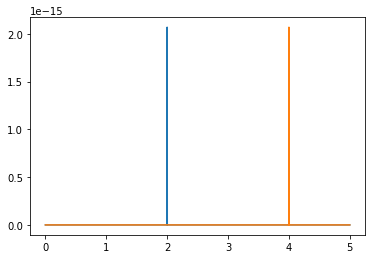

In [85]:
t_final = 5 # ns
dt = 0.0001 # ns
t_pulse = 2 # ns
t = np.arange(0,t_final,dt)
phiA = np.zeros(len(t))
phiB = np.zeros(len(t))
phiC = np.zeros(len(t))
phiD = np.zeros(len(t))

phiA[int(2/dt)] = phi_0
phiB[int(4/dt)] = phi_0
plt.plot(t,phiA)
plt.plot(t,phiB)


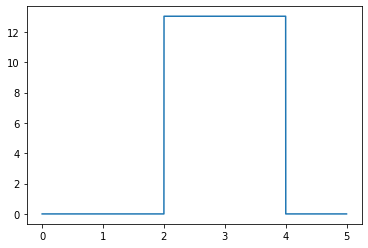

In [86]:
ip= plot_current(t,phiA,phiB,phiC,phiD)

In [87]:
print(ip)

[0. 0. 0. ... 0. 0. 0.]


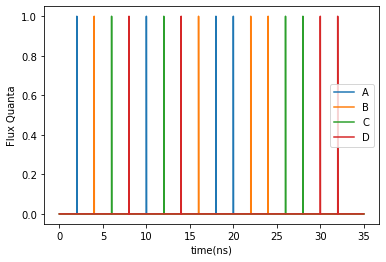

In [88]:
t_final = 35# ns
dt = 0.0001 # ns
t_pulse = 2 # ns
t = np.arange(0,t_final,dt)
phiA = np.zeros(len(t))
phiB = np.zeros(len(t))
phiC = np.zeros(len(t))
phiD = np.zeros(len(t))

phiA[int(2/dt)] = phiA[int(10/dt)] = phiA[int(18/dt)] = phiA[int(20/dt)] = phi_0
phiB[int(4/dt)] = phiB[int(16/dt)] = phiB[int(22/dt)] = phiB[int(24/dt)] = phi_0
phiC[int(6/dt)] = phiC[int(12/dt)] = phiC[int(26/dt)] = phiC[int(28/dt)] = phi_0
phiD[int(8/dt)] = phiD[int(14/dt)] = phiD[int(30/dt)] = phiD[int(32/dt)]  =phi_0



plt.plot(t,phiA/phi_0, label = 'A')
plt.plot(t,phiB/phi_0, label = 'B')
plt.plot(t,phiC/phi_0, label = 'C')
plt.plot(t,phiD/phi_0, label = 'D')
plt.xlabel('time(ns)')
plt.ylabel('Flux Quanta')
plt.legend()

Text(0, 0.5, '$i_p(t)$ ($\\mu$A)')

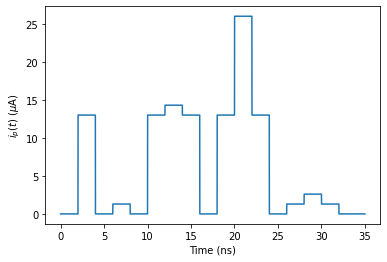

In [89]:
ip= plot_current(t,phiA,phiB,phiC,phiD)
plt.xlabel('Time (ns)')
plt.ylabel(r'$i_p(t)$ ($\mu$A)')

Ideal Z Control

In [90]:
# Parameters from Paper:

#Josephson Energies (for qubit 1):
EJ1 = hbar * 2 * pi * 11.147e9
EJ2 = hbar * 2 * pi * 11.147e9
#Charging Energy for Transmon (for qubit 1):
Ec = hbar * 2 * pi * 148.628e6 

# Operators 
a = destroy(2)
a_dag = create(2)

In [91]:
# Total Josephson Coupling Energy
def E_Jsigma (EJ1, EJ2):
    return EJ1 + EJ2

def reduced_flux(phi):
    return pi * phi / phi_0
# Effective Josephson Energy of SQUID
def E_JS(EJ1, EJ2,x, flux = True):
    d = (EJ2 - EJ1)/E_Jsigma(EJ1,EJ2)
    if flux:
        return E_Jsigma(EJ1,EJ2) *np.abs(np.cos(x)) * np.sqrt(1+(d**2)*(np.tan(x)**2))
    else:
        return E_Jsigma(EJ1,EJ2) *np.abs(np.cos(pi * M * x/ phi_0)) * np.sqrt(1+(d**2)*(np.tan(pi * M * x /phi_0)**2))
    
def ground(Ec,EJ1, EJ2,x, flux = True):
    EJ = E_JS(EJ1, EJ2,x, flux)
    return -Ec/4 - EJ

def first_excited(Ec,EJ1,EJ2,x,flux = True):
    EJ = E_JS(EJ1, EJ2,x, flux)
    return np.sqrt(8*Ec*EJ) -Ec - Ec/4 - EJ

def second_excited(Ec,EJ1,EJ2,x,flux = True):
    EJ = E_JS(EJ1, EJ2,x, flux)
    return  2 * np.sqrt(8*Ec*EJ) - 3*Ec -Ec/4  - EJ

def E10(E1,E0):
    return E1- E0

def E21(E2,E1):
    return E2-E1

def anharmonicity(E21,E10):
    return E21-E10

def qubit_freq(Ec, EJ1, EJ2,x, flux = False):
    EJ = E_JS(EJ1, EJ2,x, flux)
    return (np.sqrt(8 * Ec * EJ) - Ec)/ hbar

def d_omega_freq(w_work, w_idle):
    return w_work - w_idle

def d_omega_energy(Ec, EJ1, EJ2,x_work,x_idle, flux = False):
    EJ_work = E_JS(EJ1, EJ2,x_work, flux)
    EJ_idle = E_JS(EJ1, EJ2,x_idle, flux)
    return np.sqrt(8*Ec) * (np.sqrt(EJ_work)- np.sqrt(EJ_idle))

def qubit_ham(omega,alpha):
    return hbar*(omega* a_dag*a + (alpha/2)* a_dag*a_dag*a*a) 

def drive_ham_z(omega):
    return hbar * omega * a_dag * a

In [92]:
def square_pulse_z(t,t_start,t_gate,Imax):
    #t = np.arange(0,t_meas,dt)
    t_end = t_start+t_gate
    ip = np.zeros(len(t))
    for ii in range(len(t)):
        if (t[ii]>=t_start) and (t[ii]<=t_end):
            ip[ii] = Imax
    return ip

Text(0, 0.5, 'Inductor Loop Current ($\\mu$A)')

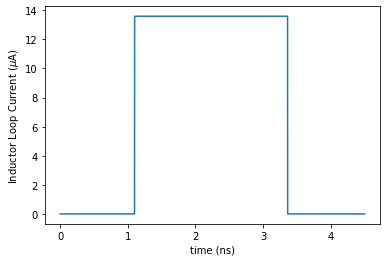

In [93]:
dt = 0.001 # ns
t_gate = 2.261 # ns
ipc = 13.58935 #ua
t_start = 1.1 # ns
t_meas = 4.5 # ns

t = np.arange(0,t_meas,dt)

ip = square_pulse_z(t,t_start,t_gate,ipc)
plt.plot (t,ip)
plt.xlabel('time (ns)')
plt.ylabel(r'Inductor Loop Current ($\mu$A)')

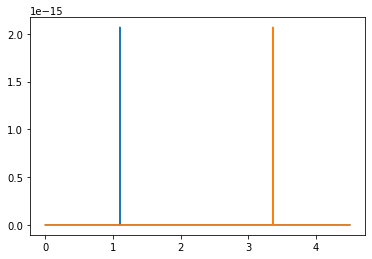

In [95]:
t = np.arange(0,t_meas,dt)
dt = 0.001 # ns
t_gate = 2.261 # ns
t_start = 1.1 # ns
t_meas = 4.5 # ns
t_end = t_start + t_gate
t = np.arange(0,t_meas,dt)

phiA = np.zeros(len(t))
phiB = np.zeros(len(t))
phiA[int(t_start/dt)] = phi_0
phiB[int(t_end/dt)] = phi_0
phiC = np.zeros(len(t))
phiD = np.zeros(len(t))
plt.plot(t,phiA/phi_0)
plt.plot(t,phiB/phi_0)

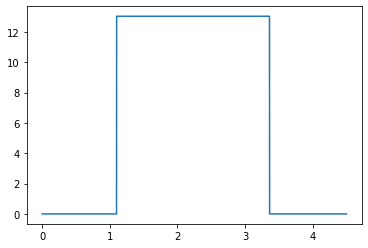

In [96]:
ip= plot_current(t,phiA,phiB,phiC,phiD)

Text(0, 0.5, 'Qubit Eigenfrequencies (GHz)')

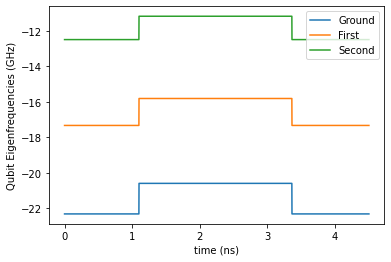

In [99]:
E0 = ground(Ec,EJ1, EJ2,ip, flux = False)
E1 = first_excited(Ec,EJ1,EJ2,ip,flux = False)
E2 = second_excited(Ec,EJ1,EJ2,ip,flux = False)
plt.plot(t,E0/(hbar * 2 * pi)*1e-9,label = 'Ground')
plt.plot(t,E1/(hbar * 2 * pi)*1e-9,label ='First')
plt.plot(t,E2/(hbar * 2 * pi)*1e-9, label = 'Second')
plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('Qubit Eigenfrequencies (GHz)')